# Code search debug setup

Here's an example setup for debugging aspects of the code_search example. This should make it easier to debug and write tests for various aspects of the model as well as provide a simple interface for exploring its performance during development.

Fairly similar to [hello_t2t.ipynb](https://github.com/tensorflow/tensor2tensor/blob/master/tensor2tensor/notebooks/hello_t2t.ipynb).

Currently appears to require tf 1.6


## Imports

In [1]:

import csv
from six import StringIO
import tempfile

from tensor2tensor.data_generators import problem
from tensor2tensor.layers import common_layers
from tensor2tensor.models import transformer
from tensor2tensor.utils import registry
from tensor2tensor.utils import t2t_model

from tensor2tensor.data_generators import generator_utils
from tensor2tensor.data_generators import text_problems
from tensor2tensor.utils import metrics

import tensorflow as tf

import tk

from tensorflow.contrib.eager.python import tfe
tfe.enable_eager_execution()
Modes = tf.estimator.ModeKeys


## Datagen

In [2]:

@registry.register_problem
class GithubFunctionDocstring(text_problems.Text2TextProblem):
  """Function and Docstring similarity Problem.
  This problem contains the data consisting of function
  and docstring pairs as CSV files. The files are structured
  such that they contain two columns without headers containing
  the docstring tokens and function tokens. The delimiter is
  ",".
  """

  DATA_PATH_PREFIX = "gs://kubeflow-examples/t2t-code-search/raw_data"

  @property
  def pair_files_list(self):
    """Return URL and file names.
    This format is a convention across the Tensor2Tensor (T2T)
    codebase. It should be noted that the file names are currently
    hardcoded. This is to preserve the semantics of a T2T problem.
    In case a change of these values is desired, one must subclass
    and override this property.
    # TODO(sanyamkapoor): Manually separate train/eval data set.
    Returns:
      A list of the format,
        [
          [
            "STRING",
            ("STRING", "STRING", ...)
          ],
          ...
        ]
      Each element is a list of size 2 where the first represents
      the source URL and the next is an n-tuple of file names.
      In this case, the tuple is of size 1 because the URL points
      to a file itself.
    """
    return [
        [
            "{}/func-doc-pairs-000{:02}-of-00100.csv".format(
                self.DATA_PATH_PREFIX, i),
            ("func-doc-pairs-000{:02}-of-00100.csv".format(i),)
        ]
        for i in range(1)
    ]

  @property
  def is_generate_per_split(self):
    return False

  @property
  def approx_vocab_size(self):
    return 2**13

  @property
  def max_samples_for_vocab(self):
    # FIXME(sanyamkapoor): This exists to handle memory explosion.
    return int(2e5)

  def get_csv_files(self, _data_dir, tmp_dir, _dataset_split):
    return [
        generator_utils.maybe_download(tmp_dir, file_list[0], uri)
        for uri, file_list in self.pair_files_list
    ]

  def generate_samples(self, data_dir, tmp_dir, dataset_split):
    """A generator to return data samples.Returns the data generator to return.
    Args:
      data_dir: A string representing the data directory.
      tmp_dir: A string representing the temporary directory and is
              used to download files if not already available.
      dataset_split: Train, Test or Eval.
    Yields:
      Each element yielded is of a Python dict of the form
        {"inputs": "STRING", "targets": "STRING", "embed_code": [0]}
    """
    csv_files = self.get_csv_files(data_dir, tmp_dir, dataset_split)

    for pairs_file in csv_files:
      tf.logging.debug("Reading {}".format(pairs_file))
      with tf.gfile.Open(pairs_file) as csv_file:
        for line in csv_file:
          reader = csv.reader(StringIO(line))
          for docstring_tokens, function_tokens in reader:
            yield {
                "inputs": docstring_tokens,
                "targets": function_tokens,
                "embed_code": [0]
            }

  def example_reading_spec(self):
    data_fields, data_items_to_decoders = super(GithubFunctionDocstring,
                                                self).example_reading_spec()
    data_fields["embed_code"] = tf.FixedLenFeature([1], dtype=tf.int64)

    data_items_to_decoders = {
      "inputs": tf.contrib.slim.tfexample_decoder.Tensor(tensor_key="inputs"),
      "targets": tf.contrib.slim.tfexample_decoder.Tensor(tensor_key="targets"),
      "embed_code": tf.contrib.slim.tfexample_decoder.Tensor(tensor_key="embed_code")
    }
    return data_fields, data_items_to_decoders

  def eval_metrics(self):  # pylint: disable=no-self-use
    return [
        metrics.Metrics.ACC
    ]


In [3]:

# Your paths here!

tmp_dir = "/mnt/nfs-east1-d/cs/tmp"
tf.gfile.MakeDirs(tmp_dir)

data_dir = "/mnt/nfs-east1-d/cs/data"
tf.gfile.MakeDirs(data_dir)


In [4]:

problem_object = GithubFunctionDocstring()

problem_object.generate_data(data_dir, tmp_dir)


INFO:tensorflow:Found vocab file: /mnt/nfs-east1-d/cs/data/vocab.github_function_docstring.8192.subwords


[2018-09-30 17:11:52,665] Found vocab file: /mnt/nfs-east1-d/cs/data/vocab.github_function_docstring.8192.subwords


INFO:tensorflow:Skipping generator because outputs files exist


[2018-09-30 17:11:52,745] Skipping generator because outputs files exist


INFO:tensorflow:Skipping shuffle because output files exist


[2018-09-30 17:11:52,759] Skipping shuffle because output files exist


## Examine examples

In [5]:
import pprint
import numpy as np

In [6]:

example = tfe.Iterator(problem_object.dataset(Modes.TRAIN, data_dir)).next()

pprint.pprint(example)


INFO:tensorflow:Reading data files from /mnt/nfs-east1-d/cs/data/github_function_docstring-train*


[2018-09-30 17:11:52,853] Reading data files from /mnt/nfs-east1-d/cs/data/github_function_docstring-train*


INFO:tensorflow:partition: 0 num_data_files: 100


[2018-09-30 17:11:52,959] partition: 0 num_data_files: 100


{'embed_code': <tf.Tensor: id=52, shape=(1,), dtype=int64, numpy=array([0])>,
 'inputs': <tf.Tensor: id=53, shape=(11,), dtype=int64, numpy=array([ 300,   14, 7463,   44, 1686, 1717, 5561,    4,  115,   18,    1])>,
 'targets': <tf.Tensor: id=54, shape=(17,), dtype=int64, numpy=
array([   7,  300,    2, 7463,   48,    3,   60,  121,    9,    3, 7463,
         48,    2,  222,   60,  121,    1])>}


In [7]:

vocab_name = "vocab.github_function_docstring.8192.subwords"

# Get the encoders from the problem
encoders = problem_object.feature_encoders(data_dir)

# Setup helper functions for encoding and decoding
def encode(input_str, output_str=None):
  """Input str to features dict, ready for inference"""
  inputs = encoders["inputs"].encode(input_str) + [1]  # add EOS id
  batch_inputs = tf.reshape(inputs, [1, -1, 1])  # Make it 3D.
  return {"inputs": batch_inputs}

def decode(integers):
  """List of ints to str"""
  integers = list(np.squeeze(integers))
  if 1 in integers:
    integers = integers[:integers.index(1)]
  return encoders["inputs"].decode(np.squeeze(integers))


In [8]:

print(decode(example["inputs"]))


make a monte carlo sampler object .


In [9]:

print(decode(example["targets"]))


def make_monty self args kwargs return self monty_cls args kwargs


## Loss

In [ ]:

# FYI: You can break these losses out and work with them interactively in tf.eager mode
# the same as you would a regular python function!


In [100]:

def rank_loss(sentence_emb, image_emb, margin=0.2):
  """Experimental rank loss, thanks to kkurach@ for the code."""
  with tf.name_scope("rank_loss"):
    # Normalize first as this is assumed in cosine similarity later.
    sentence_emb = tf.nn.l2_normalize(sentence_emb, 1)
    image_emb = tf.nn.l2_normalize(image_emb, 1)
    # Both sentence_emb and image_emb have size [batch, depth].
    scores = tf.matmul(image_emb, tf.transpose(sentence_emb))  # [batch, batch]
    diagonal = tf.diag_part(scores)  # [batch]
    cost_s = tf.maximum(0.0, margin - diagonal + scores)  # [batch, batch]
    cost_im = tf.maximum(
        0.0, margin - tf.reshape(diagonal, [-1, 1]) + scores)  # [batch, batch]
    # Clear diagonals.
    batch_size = tf.shape(sentence_emb)[0]
    empty_diagonal_mat = tf.ones_like(cost_s) - tf.eye(batch_size)
    cost_s *= empty_diagonal_mat
    cost_im *= empty_diagonal_mat

    return cost_s + cost_im
    
    return cost_s, cost_im
    
    return tf.reduce_mean(cost_s) + tf.reduce_mean(cost_im)

def slicenet_similarity_cost(inputs_encoded, targets_encoded):
  """Loss telling to be more similar to your own targets than to others."""
  # This is a first very simple version: handle variable-length by padding
  # to same length and putting everything into batch. In need of a better way.
  x, y = common_layers.pad_to_same_length(inputs_encoded, targets_encoded)
  return rank_loss(x, y)


In [114]:

def kf_loss(string_embedding, code_embedding):

  string_embedding_norm = tf.nn.l2_normalize(string_embedding, axis=1)
  code_embedding_norm = tf.nn.l2_normalize(code_embedding, axis=1)
  tf.logging.debug("string_embedding_norm: %s" % string_embedding_norm)
  tf.logging.debug("code_embedding_norm: %s" % code_embedding_norm)

  # All-vs-All cosine distance matrix, reshaped as row-major.
  cosine_dist = 1.0 - tf.matmul(string_embedding_norm, code_embedding_norm,
                                transpose_b=True)
  cosine_dist_flat = tf.reshape(cosine_dist, [-1, 1])
  tf.logging.debug("cosine_dist_flat: %s" % cosine_dist_flat)

  # Positive samples on the diagonal, reshaped as row-major.
  label_matrix = tf.eye(tf.shape(cosine_dist)[0], dtype=tf.int32)
  label_matrix_flat = tf.reshape(label_matrix, [-1])
  tf.logging.debug("label_matrix_flat: %s" % label_matrix_flat)

  logits = tf.concat([1.0 - cosine_dist_flat, cosine_dist_flat], axis=1)
  tf.logging.debug("logits: %s" % logits)

  labels = tf.one_hot(label_matrix_flat, 2)
  tf.logging.debug("labels: %s" % labels)

  loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=labels,
                                                 logits=logits)
  tf.logging.debug("loss: %s" % loss)

  return loss


In [115]:
t1 = tf.convert_to_tensor(
    np.array([[1.0, 2.0, 3.0], [3.0, 4.0, 3.0], [5.0, 6.0, 3.0]], dtype=np.float32),
    dtype=tf.float32)

t2 = tf.convert_to_tensor(
    np.array([[4.0, 3.0, 3.0], [2.0, 1.0, 3.0], [7.0, 8.0, 3.0]], dtype=np.float32),
    dtype=tf.float32)

print(t1)
print(t2)

tf.Tensor(
[[1. 2. 3.]
 [3. 4. 3.]
 [5. 6. 3.]], shape=(3, 3), dtype=float32)
tf.Tensor(
[[4. 3. 3.]
 [2. 1. 3.]
 [7. 8. 3.]], shape=(3, 3), dtype=float32)


In [117]:
print(tf.reshape(kf_loss(t2, t2), (3,3,2)))
print(tf.reshape(kf_loss(t1, t2), (3,3,2)))

tf.Tensor(
[[[1.3132617  0.69314724]
  [0.33635572 0.735665  ]
  [0.32775706 0.7199305 ]]

 [[0.33635572 0.735665  ]
  [1.3132616  0.6931471 ]
  [0.3868397  0.8258845 ]]

 [[0.32775706 0.7199305 ]
  [0.3868397  0.8258845 ]
  [1.3132617  0.69314724]]], shape=(3, 3, 2), dtype=float32)
tf.Tensor(
[[[1.2205269  0.6306621 ]
  [0.33297884 0.7294991 ]
  [0.37914097 0.8123544 ]]

 [[0.32125714 0.70796114]
  [1.2205269  0.6306621 ]
  [0.32344216 0.7119921 ]]

 [[0.32323566 0.71161145]
  [0.37153625 0.7989113 ]
  [1.3100034  0.6909199 ]]], shape=(3, 3, 2), dtype=float32)


In [ ]:

# So just a little confused here why we have a vector of two values for the distance between a pair of embeddings?
# Each value in these pairs almost exactly sum to 1


In [119]:

def kf_loss_mod(string_embedding, code_embedding):

  string_embedding_norm = tf.nn.l2_normalize(string_embedding, axis=1)
  code_embedding_norm = tf.nn.l2_normalize(code_embedding, axis=1)
  tf.logging.debug("string_embedding_norm: %s" % string_embedding_norm)
  tf.logging.debug("code_embedding_norm: %s" % code_embedding_norm)

  # All-vs-All cosine distance matrix, reshaped as row-major.
  cosine_dist = 1.0 - tf.matmul(string_embedding_norm, code_embedding_norm,
                                transpose_b=True)
  cosine_dist_flat = tf.reshape(cosine_dist, [-1, 1])
  tf.logging.debug("cosine_dist_flat: %s" % cosine_dist_flat)

  # Positive samples on the diagonal, reshaped as row-major.
  label_matrix = tf.eye(tf.shape(cosine_dist)[0], dtype=tf.int32)
  label_matrix_flat = tf.reshape(label_matrix, [-1])
  tf.logging.debug("label_matrix_flat: %s" % label_matrix_flat)

  #logits = tf.concat([1.0 - cosine_dist_flat, cosine_dist_flat], axis=1)
  logits = tf.maximum(0.0, cosine_dist_flat)
  tf.logging.debug("logits: %s" % logits)

  labels = tf.one_hot(label_matrix_flat, 1)
  tf.logging.debug("labels: %s" % labels)

  loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=labels,
                                                 logits=logits)
  tf.logging.debug("loss: %s" % loss)

  return loss


In [120]:

# Makes more sense, but still shouldn't values on diag be zero? Perhaps I missed something.

print(tf.reshape(kf_loss_mod(t2, t2), (3,3)))
print(tf.reshape(kf_loss_mod(t1, t2), (3,3)))

tf.Tensor(
[[0.6931472  0.6523636  0.6670625 ]
 [0.6523636  0.69314724 0.57598215]
 [0.6670625  0.57598215 0.6931472 ]], shape=(3, 3), dtype=float32)
tf.Tensor(
[[0.75979847 0.65807045 0.5866487 ]
 [0.67854947 0.75979847 0.67465085]
 [0.6750176  0.59750694 0.69537944]], shape=(3, 3), dtype=float32)


In [101]:

# The slicenet similarity cost produces a single loss value instead of pairwise distances

print(slicenet_similarity_cost(t2, t2))
print(slicenet_similarity_cost(t1, t2))

# If this is summed we'll get the total distance from all elements to their non-pairs, ignoring self-distances.
# Perhaps we should also consider self-distances.


(<tf.Tensor: id=99935, shape=(3, 3), dtype=float32, numpy=
array([[0.        , 0.11669868, 0.14713186],
       [0.11669844, 0.        , 0.        ],
       [0.14713186, 0.        , 0.        ]], dtype=float32)>, <tf.Tensor: id=99936, shape=(3, 3), dtype=float32, numpy=
array([[0.        , 0.11669844, 0.14713186],
       [0.11669868, 0.        , 0.        ],
       [0.14713186, 0.        , 0.        ]], dtype=float32)>)
(<tf.Tensor: id=99980, shape=(3, 3), dtype=float32, numpy=
array([[0.        , 0.2997247 , 0.1678657 ],
       [0.25770772, 0.        , 0.00305521],
       [0.10343069, 0.29179513, 0.        ]], dtype=float32)>, <tf.Tensor: id=99981, shape=(3, 3), dtype=float32, numpy=
array([[0.        , 0.2997247 , 0.29254252],
       [0.25770772, 0.        , 0.12773204],
       [0.        , 0.16711831, 0.        ]], dtype=float32)>)


## Model

In [12]:

def _get_initializer(_):
  return None

class SimilarityTransformer(t2t_model.T2TModel):
  """Transformer Model for Similarity between two strings.
  This model defines the architecture using two transformer
  networks, each of which embed a string and the loss is
  calculated as a Binary Cross-Entropy loss. Normalized
  Dot Product is used as the distance measure between two
  string embeddings.
  """

  def top(self, body_output, _):  # pylint: disable=no-self-use
    return body_output

  def body(self, features):
        
    loss_variant = self.hparams.loss_variant

    initializer = _get_initializer(self.hparams.initializer)
    docs_encoder_trainable = self.hparams.docs_encoder_trainable
    code_encoder_trainable = self.hparams.code_encoder_trainable

    with tf.variable_scope('string_embedding'):
      string_embedding = self.encode(features, 'inputs')
      tf.logging.debug("string_embedding: %s" % string_embedding)

    if 'targets' in features:
      with tf.variable_scope('code_embedding'):
        code_embedding = self.encode(features, 'targets')
        tf.logging.debug("code_embedding: %s" % code_embedding)
    
      loss = self.loss(string_embedding, code_embedding, loss_variant)
    
      return string_embedding, {"training": loss}
    
    return string_embedding, {"training": 0.0}
    
  def loss(self, string_embedding, code_embedding, loss_variant):
    """Compute either the kfnet or slicenet cosine similarity loss."""

    if loss_variant == "slicenet":
      loss = slicenet_similarity_cost(string_embedding, code_embedding)
    elif loss_variant == "kfnet":
      loss = kf_loss(string_embedding, code_embedding)
    else:
      raise ValueError("Unrecognize loss variant: %s" % loss_variant)
    return loss

  def encode(self, features, input_key):
    hparams = self._hparams
    inputs = common_layers.flatten4d3d(features[input_key])

    (encoder_input, encoder_self_attention_bias, _) = (
        transformer.transformer_prepare_encoder(inputs, problem.SpaceID.EN_TOK,
                                                hparams))

    encoder_input = tf.nn.dropout(encoder_input,
                                  1.0 - hparams.layer_prepostprocess_dropout)
    encoder_output = transformer.transformer_encoder(
        encoder_input,
        encoder_self_attention_bias,
        hparams,
        nonpadding=transformer.features_to_nonpadding(features, input_key))

    encoder_output = tf.reduce_mean(encoder_output, axis=1)

    return encoder_output

  def infer(self, features=None, **kwargs):
    del kwargs

    predictions, _ = self(features)
    return predictions


## Train setup

In [13]:

from tensor2tensor.models.transformer import transformer_base

def similarity_transformer_tiny():
  hparams = transformer_base()
  hparams.num_hidden_layers = 2
  hparams.hidden_size = 128
  hparams.filter_size = 512
  hparams.num_heads = 4
  hparams.docs_encoder_trainable = True
  hparams.code_encoder_trainable = True
  hparams.initializer = None
  hparams.loss_variant = "kfnet"
  return hparams


In [14]:

hparams = similarity_transformer_tiny()
hparams.data_dir = data_dir

p_hparams = problem_object.get_hparams(hparams)

model = SimilarityTransformer(
    hparams, tf.estimator.ModeKeys.TRAIN, p_hparams
)

batch_size = 1
train_dataset = problem_object.dataset(Modes.TRAIN, data_dir)
train_dataset = train_dataset.repeat(None).batch(batch_size)

optimizer = tf.train.AdamOptimizer()


INFO:tensorflow:Setting T2TModel mode to 'train'


[2018-09-30 17:11:53,513] Setting T2TModel mode to 'train'


INFO:tensorflow:Reading data files from /mnt/nfs-east1-d/cs/data/github_function_docstring-train*


[2018-09-30 17:11:53,517] Reading data files from /mnt/nfs-east1-d/cs/data/github_function_docstring-train*


INFO:tensorflow:partition: 0 num_data_files: 100


[2018-09-30 17:11:53,622] partition: 0 num_data_files: 100


In [106]:
tf.logging.set_verbosity(tf.logging.INFO)

## Train and examine result

In [16]:

@tfe.implicit_value_and_gradients
def loss_fn(features):
  _, losses = model(features)
  return losses["training"]

NUM_STEPS = 10

for count, example in enumerate(tfe.Iterator(train_dataset)):
  loss, gv = loss_fn(example)
  optimizer.apply_gradients(gv)

  if count % 1 == 0:
   print("Step: %d, Loss: %.3f" % (count, loss.numpy()))
  if count >= NUM_STEPS:
   break


INFO:tensorflow:Transforming feature 'inputs' with symbol_modality_8185_128.bottom


[2018-09-30 17:11:53,838] Transforming feature 'inputs' with symbol_modality_8185_128.bottom


INFO:tensorflow:Transforming 'targets' with symbol_modality_8185_128.targets_bottom


[2018-09-30 17:11:54,046] Transforming 'targets' with symbol_modality_8185_128.targets_bottom


INFO:tensorflow:Building model body


[2018-09-30 17:11:54,056] Building model body


INFO:tensorflow:Skipping T2TModel top and loss because training loss returned from body


[2018-09-30 17:11:54,304] Skipping T2TModel top and loss because training loss returned from body


Step: 0, Loss: 0.521
Step: 1, Loss: 0.382
Step: 2, Loss: 0.307
Step: 3, Loss: 0.289
Step: 4, Loss: 0.262
Step: 5, Loss: 0.252
Step: 6, Loss: 0.251
Step: 7, Loss: 0.249
Step: 8, Loss: 0.246
Step: 9, Loss: 0.239
Step: 10, Loss: 0.243


In [17]:

example = tfe.Iterator(train_dataset).next()

print(decode(example["inputs"]))
print(decode(example["targets"]))

print(model.infer({"inputs": example["inputs"]}))
print(model.infer({"inputs": example["targets"]}))


starts monitoring network notifications and recording http responses .
def StartMonitoringNetwork self self ClearResponseData self _inspector_websocket RegisterDomain Network self _OnNetworkNotification request method Network enable self _inspector_websocket SyncRequest request
tf.Tensor(
[[ 0.7172416   0.92741555  0.12348276 -0.20051704 -1.1058692   0.86038166
  -1.2172744  -1.3298419   0.745497   -0.7550367  -0.5932518  -1.4806631
   0.51983285  2.0449784  -1.5088761  -0.03365893 -0.04511219 -1.5894246
   0.5326434  -0.15864295  1.1758411  -0.36474767  1.169934    1.35163
  -0.68106705  0.37723333  1.5279374  -0.6439409   1.1116624  -1.3295312
  -0.2936      1.3362228   1.5472255   0.69980896 -0.38871604 -0.75966763
  -1.0516654   0.21517804 -0.68333787 -1.1471457  -0.4602326  -0.90439755
   1.0481467  -0.4632301   0.44710428 -0.31434947  0.11345819 -0.8577829
   2.047798    1.849212    0.83297217  1.0712117   0.01263916  0.16294779
  -1.6924348   0.34745318 -0.5920931  -0.00282303  

#### Examine distances between pairs and non-pairs

In [ ]:
import random
import string

def random_airquote_code_airquote():
  codelen = random.randint(10,100)
  code = []
  for i in range(0, codelen):
    N = random.randint(1,10)
    code.append(''.join(random.choice(string.ascii_lowercase) for _ in range(N)))
  return ' '.join(code)

def compare_to_random(query, code):
    
    code2 = random_airquote_code_airquote()

    with tfe.restore_variables_on_create(ckpt_path):

      doc_emb = model.infer(encode(query))
      code1_emb = model.infer(encode(code1))
      code2_emb = model.infer(encode(code2))

    dtrue = model.loss(doc_emb, code1_emb, "kfnet")
    dfalse = model.loss(doc_emb, code2_emb, "kfnet")
    print("Dist for true pair: %s" % dtrue)
    print("Dist for false pair: %s" % dfalse)
    
    return dtrue, dfalse


In [19]:

query = "print query"
code1 = "def my_function(query):  print(query)"
code2 = "nronfg vmo5i n6565-23 wrdnds vdmam65 3ehn bdp"

doc_emb = model.infer(encode(query))
code1_emb = model.infer(encode(code1))
code2_emb = model.infer(encode(code2))

print("Dist for true pair: %s" % model.loss(doc_emb, code1_emb, "kfnet"))
print("Dist for false pair: %s" % model.loss(doc_emb, code2_emb, "kfnet"))


Dist for true pair: tf.Tensor([[1.2818332 0.6717591]], shape=(1, 2), dtype=float32)
Dist for false pair: tf.Tensor([[1.2767197 0.6682996]], shape=(1, 2), dtype=float32)


In [67]:
compare_to_random(query, code1)

Dist for true pair: tf.Tensor([[1.2711855 0.6645619]], shape=(1, 2), dtype=float32)
Dist for false pair: tf.Tensor([[1.2465297  0.64799166]], shape=(1, 2), dtype=float32)


(<tf.Tensor: id=83353, shape=(1, 2), dtype=float32, numpy=array([[1.2711855, 0.6645619]], dtype=float32)>,
 <tf.Tensor: id=83400, shape=(1, 2), dtype=float32, numpy=array([[1.2465297 , 0.64799166]], dtype=float32)>)

In [20]:

def show_pair_non_pair_distances():

    num_steps = 10
    doc_emb_last = None
    code_emb_last = None

    for step in range(0, num_steps):

        example = tfe.Iterator(train_dataset).next()

        #print(decode(example["inputs"]))
        #print(decode(example["targets"]))

        doc_emb = model.infer({"inputs": example["inputs"]})
        code_emb = model.infer({"inputs": example["targets"]})

        print("Dist for true pair: %s" % model.loss(doc_emb, code_emb, "kfnet"))

        if doc_emb_last is not None:
          print("Dist for false pair: %s" % model.loss(doc_emb, code_emb_last, "kfnet"))
          # Assuming examples are well shuffled...

        print('\n')
        doc_emb_last = doc_emb
        code_emb_last = code_emb


In [21]:

show_pair_non_pair_distances()


Dist for true pair: tf.Tensor([[1.2899535  0.67726463]], shape=(1, 2), dtype=float32)


Dist for true pair: tf.Tensor([[1.2899222 0.6772435]], shape=(1, 2), dtype=float32)
Dist for false pair: tf.Tensor([[1.2910588 0.6780152]], shape=(1, 2), dtype=float32)


Dist for true pair: tf.Tensor([[1.2851241  0.67398864]], shape=(1, 2), dtype=float32)
Dist for false pair: tf.Tensor([[1.2964038  0.68164814]], shape=(1, 2), dtype=float32)


Dist for true pair: tf.Tensor([[1.2921448  0.67875284]], shape=(1, 2), dtype=float32)
Dist for false pair: tf.Tensor([[1.2831182 0.6726295]], shape=(1, 2), dtype=float32)


Dist for true pair: tf.Tensor([[1.3063977  0.68845767]], shape=(1, 2), dtype=float32)
Dist for false pair: tf.Tensor([[1.3056698  0.68796104]], shape=(1, 2), dtype=float32)


Dist for true pair: tf.Tensor([[1.2883658 0.6761871]], shape=(1, 2), dtype=float32)
Dist for false pair: tf.Tensor([[1.289762  0.6771347]], shape=(1, 2), dtype=float32)


Dist for true pair: tf.Tensor([[1.281821  0.671

## Initiate a long training run

Assuming relevant model and problem versions are in t2t_usr_dir

In [ ]:

# Train locally, e.g. using tiny hparams to check that things run okay.

!t2t-trainer --t2t_usr_dir=/mnt/nfs-east1-d/work/tk/tk \
    ...


In [2]:

from tk.experiment import configure_experiment, T2TExperiment


Instructions for updating:
Use the retry module or similar alternatives.


In [6]:

# TODO: Your favorite way to launch jobs here, e.g. Faring, ksonnet, a Python
# wrapper around ksonnet, etc.

# In my case I'm currently using this (unsupported) library

args = configure_experiment("cs-dev-100k",
                             problem="github_function_docstring",
                             num_gpu_per_worker=1,
                             hparams_set="similarity_transformer_tiny",
                             model="similarity_transformer_dev",
                             extra_hparams={
                             },
                             num_steps=100000)
                             #base_image="gcr.io/kubeflow-rl/common-base:0.0.3")

job = T2TExperiment(**args)
job.run()


train_args:
{'data_dir': '/mnt/nfs-east1-d/data',
 'dbgprofile': False,
 'hparams': "''",
 'hparams_set': 'similarity_transformer_tiny',
 'log_device_placement': False,
 'model': 'similarity_transformer_dev',
 'output_dir': '/mnt/nfs-east1-d/work/tk/output',
 'problem': 'github_function_docstring',
 'profile': False,
 'ps_gpu': 1,
 'save_checkpoints_secs': 1800,
 'schedule': 'train',
 'ssd_mount_path': '/mnt/disks/ssd0',
 'train_steps': 100000,
 'worker_gpu': 1,
 'worker_gpu_memory_fraction': 0.95}


In [ ]:
# So the above trains but doesn't make any progress. Need a way to test loss functions
# locally with batch sizes greater than 1. Training could be improved either with an
# improved loss function or an improved training strategy (e.g. pre-training).

# On the cloud this is training with batch size 4096.


In [4]:

# Works with multiple GPUs?

args = configure_experiment("cs-dev-gpu4",
                             problem="github_function_docstring",
                             hparams_set="similarity_transformer_tiny",
                             model="similarity_transformer_dev",
                             extra_hparams={
                             },
                             num_gpu_per_worker=4,
                             num_steps=1000)

job = T2TExperiment(**args)
job.run()


train_args:
{'data_dir': '/mnt/nfs-east1-d/data',
 'dbgprofile': False,
 'hparams': "''",
 'hparams_set': 'similarity_transformer_tiny',
 'log_device_placement': False,
 'model': 'similarity_transformer_dev',
 'output_dir': '/mnt/nfs-east1-d/work/tk/output',
 'problem': 'github_function_docstring',
 'profile': False,
 'ps_gpu': 1,
 'save_checkpoints_secs': 1800,
 'schedule': 'train',
 'ssd_mount_path': '/mnt/disks/ssd0',
 'train_steps': 1000,
 'worker_gpu': 4,
 'worker_gpu_memory_fraction': 0.95}


INFO:tensorflow:Identifying event files in experiment subdirectories...


[2018-10-13 14:42:05,575] Identifying event files in experiment subdirectories...


INFO:tensorflow:Processing experiment events (1 of 2)


[2018-10-13 14:42:06,609] Processing experiment events (1 of 2)


INFO:tensorflow:Processing experiment events (2 of 2)


[2018-10-13 14:42:06,926] Processing experiment events (2 of 2)


INFO:tensorflow:Finished loading event data for comparison.


[2018-10-13 14:42:07,243] Finished loading event data for comparison.


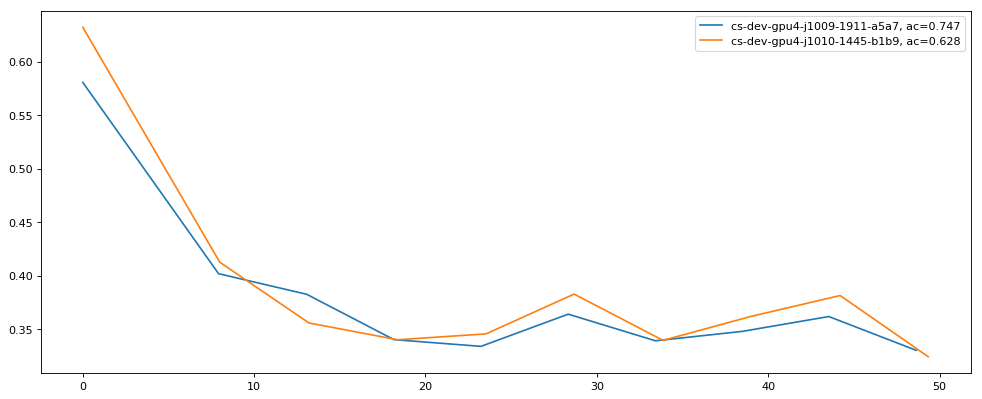

In [2]:
from tk.allen_demo import event_data_for_comparison, show_experiment_loss
%matplotlib inline

experiment_data = event_data_for_comparison("gs://kubeflow-rl-checkpoints/comparisons/cs-dev-gpu4*")
show_experiment_loss(experiment_data)


In [3]:

# Works distributed?

args = configure_experiment("cs-dev-ps4",
                             problem="github_function_docstring",
                             num_gpu_per_worker=1,
                             hparams_set="similarity_transformer_tiny",
                             model="similarity_transformer_dev",
                             extra_hparams={
                             },
                             num_ps=4,
                             num_steps=1000)

job = T2TExperiment(**args)
job.run()

# This looks mis-configured - currently master doesn't wait for / connect to workers.


train_args:
{'data_dir': '/mnt/nfs-east1-d/data',
 'dbgprofile': False,
 'hparams': "''",
 'hparams_set': 'similarity_transformer_tiny',
 'log_device_placement': False,
 'model': 'similarity_transformer_dev',
 'output_dir': '/mnt/nfs-east1-d/work/tk/output',
 'problem': 'github_function_docstring',
 'profile': False,
 'ps_gpu': 1,
 'save_checkpoints_secs': 1800,
 'schedule': 'train',
 'ssd_mount_path': '/mnt/disks/ssd0',
 'train_steps': 1000,
 'worker_gpu': 1,
 'worker_gpu_memory_fraction': 0.95}


In [5]:

args = configure_experiment("cs-dev-base",
                            problem="github_function_docstring",
                            hparams_set="similarity_transformer_tiny",
                            model="similarity_transformer_dev",
                            extra_hparams={
                            },
                            num_gpu_per_worker=1,
                            num_steps=1000,
                            base_image="gcr.io/kubeflow-rl/common-base:0.0.3")

job = T2TExperiment(**args)
job.run()

# Works with new common base?


train_args:
{'data_dir': '/mnt/nfs-east1-d/data',
 'dbgprofile': False,
 'hparams': "''",
 'hparams_set': 'similarity_transformer_tiny',
 'log_device_placement': False,
 'model': 'similarity_transformer_dev',
 'output_dir': '/mnt/nfs-east1-d/work/tk/output',
 'problem': 'github_function_docstring',
 'profile': False,
 'ps_gpu': 1,
 'save_checkpoints_secs': 1800,
 'schedule': 'train',
 'ssd_mount_path': '/mnt/disks/ssd0',
 'train_steps': 1000,
 'worker_gpu': 1,
 'worker_gpu_memory_fraction': 0.95}


In [ ]:

# Do kind of need to be able to test run losses with batch size greater than 1 if it's a
# batch-wide instead of element-wise loss... 

# Ability to unit test losses locally with batch size > 1.
# Pre-training, markov clustering loss


## Examine trained model

In [22]:

# The path to checkpoints for the newly trained model, accessible to local FS

ckpt_path = None


#### Compute the distance for pair and non-pair

In [69]:
query = "print query"
code = "def my_function(query):  print(query)"

with tfe.restore_variables_on_create(ckpt_path):
    compare_to_random(query, code)

Dist for true pair: tf.Tensor([[1.2757524 0.6676459]], shape=(1, 2), dtype=float32)
Dist for false pair: tf.Tensor([[1.2516866  0.65144634]], shape=(1, 2), dtype=float32)


In [70]:

with tfe.restore_variables_on_create(ckpt_path):
    show_pair_non_pair_distances()


Dist for true pair: tf.Tensor([[1.2839055  0.67316276]], shape=(1, 2), dtype=float32)


Dist for true pair: tf.Tensor([[1.2889736  0.67659956]], shape=(1, 2), dtype=float32)
Dist for false pair: tf.Tensor([[1.2806787 0.6709776]], shape=(1, 2), dtype=float32)


Dist for true pair: tf.Tensor([[1.291646 0.678414]], shape=(1, 2), dtype=float32)
Dist for false pair: tf.Tensor([[1.2848523  0.67380446]], shape=(1, 2), dtype=float32)


Dist for true pair: tf.Tensor([[1.2833872 0.6728116]], shape=(1, 2), dtype=float32)
Dist for false pair: tf.Tensor([[1.2894423 0.6769176]], shape=(1, 2), dtype=float32)


Dist for true pair: tf.Tensor([[1.28843   0.6762306]], shape=(1, 2), dtype=float32)
Dist for false pair: tf.Tensor([[1.2856084  0.67431694]], shape=(1, 2), dtype=float32)


Dist for true pair: tf.Tensor([[1.2573394 0.65524  ]], shape=(1, 2), dtype=float32)
Dist for false pair: tf.Tensor([[1.265234  0.6605499]], shape=(1, 2), dtype=float32)


Dist for true pair: tf.Tensor([[1.2984159  0.68301743

#### Re-build the search index with the new model

In [26]:

# TODO: For the sake of model development, it would be nice if this could be done with a single command,
# provided the path to new checkpoints, and be triggered from the notebook.

def rebuild_index(ckpt_path):
  """Trigger a re-build of the search index.
  
  i.e. triggers external infrastructure to re-compute embeddings
  
  Returns:
      index or index ID?
  """
    
  index_id = None

  return index_id

index_id = rebuild_index(ckpt_path)


#### Run queries against the index

In [29]:

def search(query, ckpt_path, index_id):

  with tfe.restore_variables_on_create(ckpt_path):
    doc_emb = model.infer(encode(query))

  # TODO: Search `doc_emb` against index with `index_id`
  hits = []

  return hits


query = "hello world"

hits = search(query, ckpt_path, None)

print("Query: %s" % query)
print("Hits:")
pprint.pprint(hits)


Query: hello world
Hits:
[]


#### Compute interpretable quality measures

In [31]:

# TODO: Trigger calculation of an interpretable measure of quality, along
# the lines of
# https://github.com/kubeflow/examples/issues/254#issuecomment-425606539

def compute_quality(ckpt_path, index_id):
  pass

compute_quality(ckpt_path, None)


In [ ]:
## Export and serving